In [23]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [24]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [25]:
#conectando com API do azure para buscar imagens
key = os.environ.get('AZURE_SEARCH_KEY', '1b4cc03c770d424089107f54293a8875')

In [26]:
search_images_bing

<function fastbook.search_images_bing>

In [27]:
#confirmando a busca por tulipas na API
def search_images_bing(key, term, max_images: int = 150, **kwargs):    
     params = {'q':term, 'count':max_images}
     headers = {"Ocp-Apim-Subscription-Key":"1b4cc03c770d424089107f54293a8875"}
     search_url = "https://api.bing.microsoft.com/v7.0/images/search"
     response = requests.get(search_url, headers=headers, params=params)
     response.raise_for_status()
     search_results = response.json()    
     return L(search_results['value'])

results = search_images_bing(key, 'tulip')
ims = results.attrgot('content_url')
len(ims)

150

In [28]:
#organizando as categorias
flower_types = 'tulip','sunflower','orchid'
path = Path('flowers')

In [29]:
#para cada item do flower_types, vai criar uma caminho geral flowers seguido de sua categoria e então de suas imagens.
if not path.exists():
    path.mkdir()
    for o in flower_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} flower')
        download_images(dest, urls=results.attrgot('content_url'))

In [30]:
#verificando se o caminho ficou exatamente como descrito na célula anterior
fns = get_image_files(path)
fns

(#450) [Path('flowers/orchid/Image_48.jpg'),Path('flowers/orchid/Image_62.jpg'),Path('flowers/orchid/Image_23.jpg'),Path('flowers/orchid/Image_74.jpg'),Path('flowers/orchid/Image_89.jpg'),Path('flowers/orchid/Image_42.jpg'),Path('flowers/orchid/Image_148.jpg'),Path('flowers/orchid/Image_78.jpg'),Path('flowers/orchid/Image_92.jpg'),Path('flowers/orchid/Image_150.jpg')...]

In [31]:
#verificando se algum dos arquivos baixados estão corrompidos
failed = verify_images(fns)
failed

(#0) []

In [32]:
#remove as imagens corrompidas
failed.map(Path.unlink);

In [33]:
# Criando um dataloader bem detalhado, passando o detalhamento por parâmetro // Dataloader é a classe entendível pra ser treinada
# O primeiro item da tupla passada pelo parâmetro "blocks" diz que a primeira é a variável independente que no nosso caso são as imagens
# O segundo item da tupla passada pelo parâmetro "blocks" doz qie a segunda variável é dependente que no nosso caso são as categorias de flores
# O segundo parâmetro é o caminho onde estão as imagens
# O terceiro parâmetro diz a respeito do conjunto de validação e sua aleatóridade
# No quarto parâmetro o get_y é a variável dependente, daí passamos o parent_label, pois ele vai usar o nome das pastas como as categorias
# No quinto parâmetro colocamos nossas imagens no mesmo tamanho 64X64
flowers = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))
flowers

In [34]:
!pip install bing-image-downloader
from bing_image_downloader import downloader

for q in ['tulip','sunflower','orchid']:
  downloader.download(q, limit=150, output_dir="flowers", adult_filter_off=True, force_replace=False, timeout=5)



[!!]Indexing page: 1

[%] Indexed 150 Images on Page 1.


[%] Downloading Image #1 from https://northwestphotos.files.wordpress.com/2012/04/100_0198.jpg
[%] File Downloaded !

[%] Downloading Image #2 from http://www.photos-public-domain.com/wp-content/uploads/2012/04/pink-tulip-with-one-petal-open.jpg
[%] File Downloaded !

[%] Downloading Image #3 from http://img3.wikia.nocookie.net/__cb20080709190044/symbolism/images/8/86/Red_tulip-2529.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://cdn.shopify.com/s/files/1/1902/7917/products/Tulip-Princess-Irene-2017_x2000_crop_center.jpg?v=1571652790
[%] File Downloaded !

[%] Downloading Image #5 from https://www.hadeco.co.za/wp-content/uploads/2016/01/Tulip-Apeldoorn-2.jpg
[%] File Downloaded !

[%] Downloading Image #6 from http://3.bp.blogspot.com/-V8JMp5LHNbc/UybFxXNGprI/AAAAAAAAAbg/DhwDWZSzpNY/s1600/Tulip-Pictures-3.jpg
[%] File Downloaded !

[%] Downloading Image #7 from https://cdn.shopify.com/s/files/1/1902/7917/produ

In [35]:
# Ainda precisamos dizer a fastai a fonte real de nossos dados - neste caso, o caminho onde as imagens podem ser encontradas.
dls = flowers.dataloaders(path)

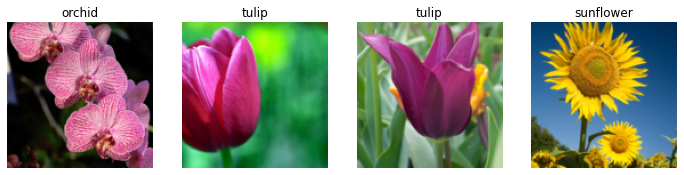

In [36]:
# dando uma olhada nas imagens que obtivemos e passamos como conjunto de validação
dls.valid.show_batch(max_n=4, nrows=1)

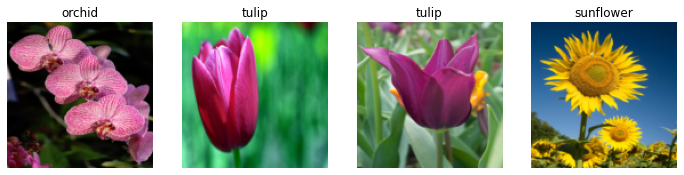

In [37]:
# Redimensionando imagens para preencher com pretos, comprimi-las ou esticá-las
flowers = flowers.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = flowers.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

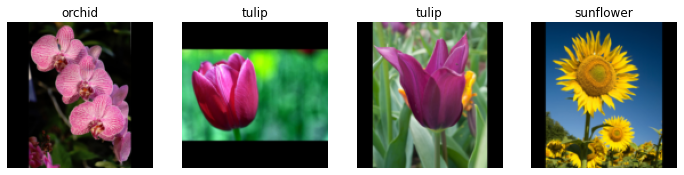

In [38]:
flowers = flowers.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = flowers.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

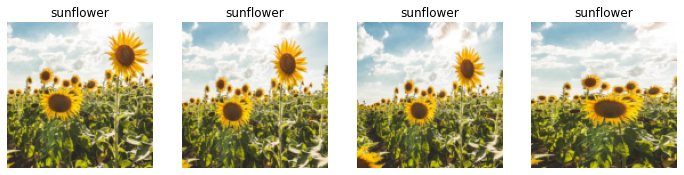

In [39]:
# Redimensionando sem perder partes da imagem
flowers = flowers.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = flowers.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

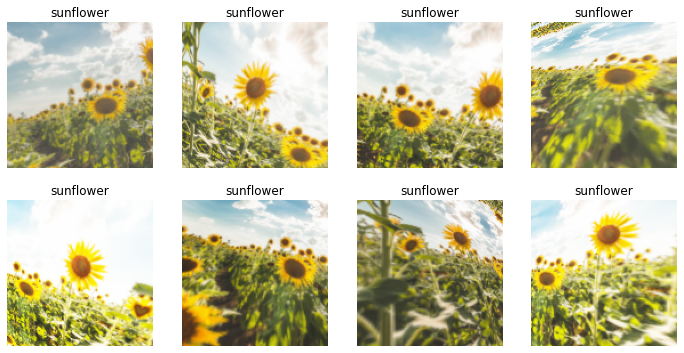

In [41]:
# Aqui estamos gerando novas imagens apenas "brincando" com as mesmas imagens
flowers = flowers.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = flowers.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [42]:
# Aqui estamos modificando nossas imagens para gerar novas
flowers = flowers.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = flowers.dataloaders(path)

In [43]:
# Aqui treinamos nosso modelo
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.624855,0.895597,0.333333,01:33


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,0.293881,0.147614,0.044444,01:59
1,0.230481,0.033100,0.011111,02:02
2,0.167683,0.018091,0.000000,01:59
3,0.146645,0.018925,0.000000,01:59


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


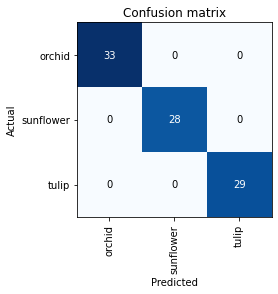

In [44]:
# Aqui vemos a matrix de confusão, utilizada para detectar como estão os nossos erros
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

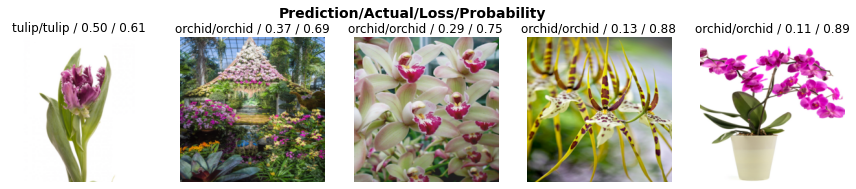

In [45]:
# A seguir as imagens com maior probabilidade de erro
# previsão / real / perda /probabilidade
interp.plot_top_losses(5, nrows=1)

In [46]:
#Aqui ajudamos o nosso modelo a entender algumas imagens
cleaner = ImageClassifierCleaner(learn)
cleaner

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [47]:
# A primeira linha comentada desvincula todas as imagens que colocamos delete na opção e a segunda move as imagens para as pastas q designamos
# Descomenta e treina novamente o modelo, e confira se a precisão melhora
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [48]:
# exportando nosso modelo
learn.export()

In [49]:
# confirmando se gerou o arquivo de exportação
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [50]:
# carregando o arquivo exportado
learn_inf = load_learner(path/'export.pkl')

In [ ]:
# predizendo uma imagem aleatória
learn_inf.predict('/content/gdrive/My Drive/grizzly.jpg')

In [51]:
# observamos as categorias
learn_inf.dls.vocab

['orchid', 'sunflower', 'tulip']

In [52]:
# Cria um botão de upload
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [53]:
# fakeamos a inserção de imagem com o botão
btn_upload = SimpleNamespace(data = ['/content/gdrive/My Drive/tulipa.jpg'])

In [54]:
# Pegamos a imagem que fizemos upload com o botão
img = PILImage.create(btn_upload.data[-1])

In [55]:
# Observamos a imagem que fizmos upload
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [56]:
# Aqui fazemos a previsão
pred,pred_idx,probs = learn_inf.predict(img)

In [57]:
# Aqui mostramos a previsão
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: tulip; Probability: 0.9996')

In [58]:
# Aqui geramos um botão de classificação
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [59]:
# Aqui dizemos pra quando clicar no botão, qual função deve ser executada
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [60]:
# Retornando o botão para upload para a imagem
btn_upload = widgets.FileUpload()

In [62]:
# Criamos um espaço com tudo que criamos
VBox([widgets.Label('Select your flower!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [ ]:
# instalações necessárias caso não tenha feito para transformar em um web app
# !pip install voila
# !jupyter serverextension enable voila —sys-prefix

### Deploying your app

For at least the initial prototype of your application, and for any hobby projects that you want to show off, you can easily host them for free. The best place and the best way to do this will vary over time, so check the [book's website](https://book.fast.ai/) for the most up-to-date recommendations. As we're writing this book in early 2020 the simplest (and free!) approach is to use [Binder](https://mybinder.org/). To publish your web app on Binder, you follow these steps:

1. Add your notebook to a [GitHub repository](http://github.com/).
2. Paste the URL of that repo into Binder's URL, as shown in <<deploy-binder>>.
3. Change the File dropdown to instead select URL.
4. In the "URL to open" field, enter `/voila/render/name.ipynb` (replacing `name` with the name of for your notebook).
5. Click the clickboard button at the bottom right to copyt the URL and paste it somewhere safe. 
6. Click Launch.

<img alt="Deploying to Binder" width="800" caption="Deploying to Binder" id="deploy-binder" src="https://github.com/fastai/fastbook/blob/master/images/att_00001.png?raw=1">

The first time you do this, Binder will take around 5 minutes to build your site. Behind the scenes, it is finding a virtual machine that can run your app, allocating storage, collecting the files needed for Jupyter, for your notebook, and for presenting your notebook as a web application.

Finally, once it has started the app running, it will navigate your browser to your new web app. You can share the URL you copied to allow others to access your app as well.

For other (both free and paid) options for deploying your web app, be sure to take a look at the [book's website](https://book.fast.ai/).

You may well want to deploy your application onto mobile devices, or edge devices such as a Raspberry Pi. There are a lot of libraries and frameworks that allow you to integrate a model directly into a mobile application. However, these approaches tend to require a lot of extra steps and boilerplate, and do not always support all the PyTorch and fastai layers that your model might use. In addition, the work you do will depend on what kind of mobile devices you are targeting for deployment—you might need to do some work to run on iOS devices, different work to run on newer Android devices, different work for older Android devices, etc. Instead, we recommend wherever possible that you deploy the model itself to a server, and have your mobile or edge application connect to it as a web service.

There are quite a few upsides to this approach. The initial installation is easier, because you only have to deploy a small GUI application, which connects to the server to do all the heavy lifting. More importantly perhaps, upgrades of that core logic can happen on your server, rather than needing to be distributed to all of your users. Your server will have a lot more memory and processing capacity than most edge devices, and it is far easier to scale those resources if your model becomes more demanding. The hardware that you will have on a server is also going to be more standard and more easily supported by fastai and PyTorch, so you don't have to compile your model into a different form.

There are downsides too, of course. Your application will require a network connection, and there will be some latency each time the model is called. (It takes a while for a neural network model to run anyway, so this additional network latency may not make a big difference to your users in practice. In fact, since you can use better hardware on the server, the overall latency may even be less than if it were running locally!) Also, if your application uses sensitive data then your users may be concerned about an approach which sends that data to a remote server, so sometimes privacy considerations will mean that you need to run the model on the edge device (it may be possible to avoid this by having an *on-premise* server, such as inside a company's firewall). Managing the complexity and scaling the server can create additional overhead too, whereas if your model runs on the edge devices then each user is bringing their own compute resources, which leads to easier scaling with an increasing number of users (also known as *horizontal scaling*).

> A: I've had a chance to see up close how the mobile ML landscape is changing in my work. We offer an iPhone app that depends on computer vision, and for years we ran our own computer vision models in the cloud. This was the only way to do it then since those models needed significant memory and compute resources and took minutes to process inputs. This approach required building not only the models (fun!) but also the infrastructure to ensure a certain number of "compute worker machines" were absolutely always running (scary), that more machines would automatically come online if traffic increased, that there was stable storage for large inputs and outputs, that the iOS app could know and tell the user how their job was doing, etc. Nowadays Apple provides APIs for converting models to run efficiently on device and most iOS devices have dedicated ML hardware, so that's the strategy we use for our newer models. It's still not easy but in our case it's worth it, for a faster user experience and to worry less about servers. What works for you will depend, realistically, on the user experience you're trying to create and what you personally find is easy to do. If you really know how to run servers, do it. If you really know how to build native mobile apps, do that. There are many roads up the hill.

Overall, we'd recommend using a simple CPU-based server approach where possible, for as long as you can get away with it. If you're lucky enough to have a very successful application, then you'll be able to justify the investment in more complex deployment approaches at that time.

Congratulations, you have successfully built a deep learning model and deployed it! Now is a good time to take a pause and think about what could go wrong.